In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36495/status,
Dashboard: /proxy/36495/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35673,Workers: 4
Dashboard: /proxy/36495/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:37227,Total threads: 4
Dashboard: /proxy/34021/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:45115,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

In [6]:
uas_ssp45 = {}; vas_ssp45 = {}
uas_ssp45['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas']
vas_ssp45['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp4.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp4.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp45[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp45[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [7]:
uas_ssp85 = {}; vas_ssp85 = {}
uas_ssp85['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas']
vas_ssp85['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp8.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp8.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp85[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp85[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [8]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [9]:
uas_DJF_hist = {}
vas_DJF_hist = {}
for k in keys:
    uas_DJF_hist[k] = uas[k].where(uas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF_hist[k] = vas[k].where(vas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
for k in model_keys:
    uas_DJF_hist[k] = uas_cmip[k].where(uas_cmip[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    uas_DJF_hist[k]['time'] = uas_DJF_hist['cmip6']['time'].values
    vas_DJF_hist[k] = vas_cmip[k].where(vas_cmip[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF_hist[k]['time'] = vas_DJF_hist['cmip6']['time'].values

In [10]:
uas_JJA_hist = {}
vas_JJA_hist = {}
for k in keys:
    uas_JJA_hist[k] = uas[k].where(uas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA_hist[k] = vas[k].where(vas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
for k in model_keys:
    uas_JJA_hist[k] = uas_cmip[k].where(uas_cmip[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    uas_JJA_hist[k]['time'] = uas_JJA_hist['cmip6']['time'].values
    vas_JJA_hist[k] = vas_cmip[k].where(vas_cmip[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA_hist[k]['time'] = vas_JJA_hist['cmip6']['time'].values

In [11]:
uas_DJF_ssp45 = {}
vas_DJF_ssp45 = {}
for k in ['cmip6']+model_keys:
    uas_DJF_ssp45[k] = uas_ssp45[k].where(uas_ssp45[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF_ssp45[k] = vas_ssp45[k].where(vas_ssp45[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    if k != 'cmip6':
        uas_DJF_ssp45[k]['time'] = uas_DJF_ssp45['cmip6']['time'].values
        vas_DJF_ssp45[k]['time'] = vas_DJF_ssp45['cmip6']['time'].values

uas_DJF_ssp85 = {}
vas_DJF_ssp85 = {}
for k in ['cmip6']+model_keys:
    uas_DJF_ssp85[k] = uas_ssp85[k].where(uas_ssp85[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF_ssp85[k] = vas_ssp85[k].where(vas_ssp85[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    if k != 'cmip6':
        uas_DJF_ssp85[k]['time'] = uas_DJF_ssp85['cmip6']['time'].values
        vas_DJF_ssp85[k]['time'] = vas_DJF_ssp85['cmip6']['time'].values

In [12]:
uas_JJA_ssp45 = {}
vas_JJA_ssp45 = {}
for k in ['cmip6']+model_keys:
    uas_JJA_ssp45[k] = uas_ssp45[k].where(uas_ssp45[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA_ssp45[k] = vas_ssp45[k].where(vas_ssp45[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    if k != 'cmip6':
        uas_JJA_ssp45[k]['time'] = uas_JJA_ssp45['cmip6']['time'].values
        vas_JJA_ssp45[k]['time'] = vas_JJA_ssp45['cmip6']['time'].values

uas_JJA_ssp85 = {}
vas_JJA_ssp85 = {}
for k in ['cmip6']+model_keys:
    uas_JJA_ssp85[k] = uas_ssp85[k].where(uas_ssp85[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA_ssp85[k] = vas_ssp85[k].where(vas_ssp85[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    if k != 'cmip6':
        uas_JJA_ssp85[k]['time'] = uas_JJA_ssp85['cmip6']['time'].values
        vas_JJA_ssp85[k]['time'] = vas_JJA_ssp85['cmip6']['time'].values

In [13]:
u_ave_DJF = {}; v_ave_DJF = {}
u_ave_JJA = {}; v_ave_JJA = {}
for k in keys+model_keys:
    u_ave_DJF[k] = (uas_DJF_hist[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_DJF[k] = (vas_DJF_hist[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_JJA[k] = (uas_JJA_hist[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_JJA[k] = (vas_JJA_hist[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

u_ave_DJF_ssp45 = {}; v_ave_DJF_ssp45 = {}
u_ave_JJA_ssp45 = {}; v_ave_JJA_ssp45 = {}
for k in ['cmip6']+model_keys:
    u_ave_DJF_ssp45[k] = (uas_DJF_ssp45[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_DJF_ssp45[k] = (vas_DJF_ssp45[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_JJA_ssp45[k] = (uas_JJA_ssp45[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_JJA_ssp45[k] = (vas_JJA_ssp45[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
u_ave_DJF_ssp85 = {}; v_ave_DJF_ssp85 = {}
u_ave_JJA_ssp85 = {}; v_ave_JJA_ssp85 = {}
for k in ['cmip6']+model_keys:
    u_ave_DJF_ssp85[k] = (uas_DJF_ssp85[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_DJF_ssp85[k] = (vas_DJF_ssp85[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_JJA_ssp85[k] = (uas_JJA_ssp85[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_JJA_ssp85[k] = (vas_JJA_ssp85[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

### STD

In [14]:
u_ave_xarray_DJF_hist = u_ave_DJF['cmip6']
v_ave_xarray_DJF_hist = v_ave_DJF['cmip6']
for k in model_keys:
    u_ave_xarray_DJF_hist = xr.concat([u_ave_xarray_DJF_hist, u_ave_DJF[k]], dim = 'model')
    v_ave_xarray_DJF_hist = xr.concat([v_ave_xarray_DJF_hist, v_ave_DJF[k]], dim = 'model')
u_ave_xarray_DJF_hist['model'] = ['cmip6']+model_keys
v_ave_xarray_DJF_hist['model'] = ['cmip6']+model_keys

u_ave_xarray_DJF_ssp45 = u_ave_DJF_ssp45['cmip6']
v_ave_xarray_DJF_ssp45 = v_ave_DJF_ssp45['cmip6']
for k in model_keys:
    u_ave_xarray_DJF_ssp45 = xr.concat([u_ave_xarray_DJF_ssp45, u_ave_DJF_ssp45[k]], dim = 'model')
    v_ave_xarray_DJF_ssp45 = xr.concat([v_ave_xarray_DJF_ssp45, v_ave_DJF_ssp45[k]], dim = 'model')
u_ave_xarray_DJF_ssp45['model'] = ['cmip6']+model_keys
v_ave_xarray_DJF_ssp45['model'] = ['cmip6']+model_keys

u_ave_xarray_DJF_ssp85 = u_ave_DJF_ssp85['cmip6']
v_ave_xarray_DJF_ssp85 = v_ave_DJF_ssp85['cmip6']
for k in model_keys:
    u_ave_xarray_DJF_ssp85 = xr.concat([u_ave_xarray_DJF_ssp85, u_ave_DJF_ssp85[k]], dim = 'model')
    v_ave_xarray_DJF_ssp85 = xr.concat([v_ave_xarray_DJF_ssp85, v_ave_DJF_ssp85[k]], dim = 'model')
u_ave_xarray_DJF_ssp85['model'] = ['cmip6']+model_keys
v_ave_xarray_DJF_ssp85['model'] = ['cmip6']+model_keys

In [15]:
u_sd_DJF_hist = u_ave_xarray_DJF_hist.sel(model = model_keys).std('model')
v_sd_DJF_hist = v_ave_xarray_DJF_hist.sel(model = model_keys).std('model')
u_sd_DJF_ssp45 = u_ave_xarray_DJF_ssp45.sel(model = model_keys).std('model')
v_sd_DJF_ssp45 = v_ave_xarray_DJF_ssp45.sel(model = model_keys).std('model')
u_sd_DJF_ssp85 = u_ave_xarray_DJF_ssp85.sel(model = model_keys).std('model')
v_sd_DJF_ssp85 = v_ave_xarray_DJF_ssp85.sel(model = model_keys).std('model')

In [16]:
MK_class = Mann_Kendall_test(-u_ave_xarray_DJF_hist, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_DJF_hist = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_DJF_hist, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_DJF_hist = MK_class.compute()

In [17]:
MK_class = Mann_Kendall_test(-u_ave_xarray_DJF_ssp85, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_DJF_ssp85 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_DJF_ssp85, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_DJF_ssp85 = MK_class.compute()

In [18]:
MK_class = Mann_Kendall_test(-u_ave_xarray_DJF_ssp45, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_DJF_ssp45 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_DJF_ssp45, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_DJF_ssp45 = MK_class.compute()

In [19]:
u_re_concat = u_ave_DJF['cmip6']
v_re_concat = v_ave_DJF['cmip6']
for k in keys[:-1]:
    u_ave_DJF[k]['time'] = u_ave_DJF['cmip6']['time']
    u_re_concat = xr.concat([u_re_concat, u_ave_DJF[k]], dim = 'model')
    v_ave_DJF[k]['time'] = v_ave_DJF['cmip6']['time']
    v_re_concat = xr.concat([v_re_concat, v_ave_DJF[k]], dim = 'model')
u_re_concat['model'] = ['cmip6']+keys[:-1]
v_re_concat['model'] = ['cmip6']+keys[:-1]

MK_class = Mann_Kendall_test(-u_re_concat, 'time', coords_name = {'time':'time', 'model':'x'})
ut_re_DJF = MK_class.compute()
MK_class = Mann_Kendall_test(v_re_concat, 'time', coords_name = {'time':'time', 'model':'x'})
vt_re_DJF = MK_class.compute()

# DJF plot

In [20]:
legend_elements = [Line2D([0], [0], color = 'k', lw = 3, label = 'CMIP6 MMM historical period'),
                   Line2D([0], [0], color = cmocean.cm.balance(.2), lw = 3, label = 'CMIP6 MMM SSP245'),
                   Line2D([0], [0], color = cmocean.cm.balance(.8), lw = 3, label = 'CMIP6 MMM SSP585'),
                   Line2D([0], [0], color = 'm', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

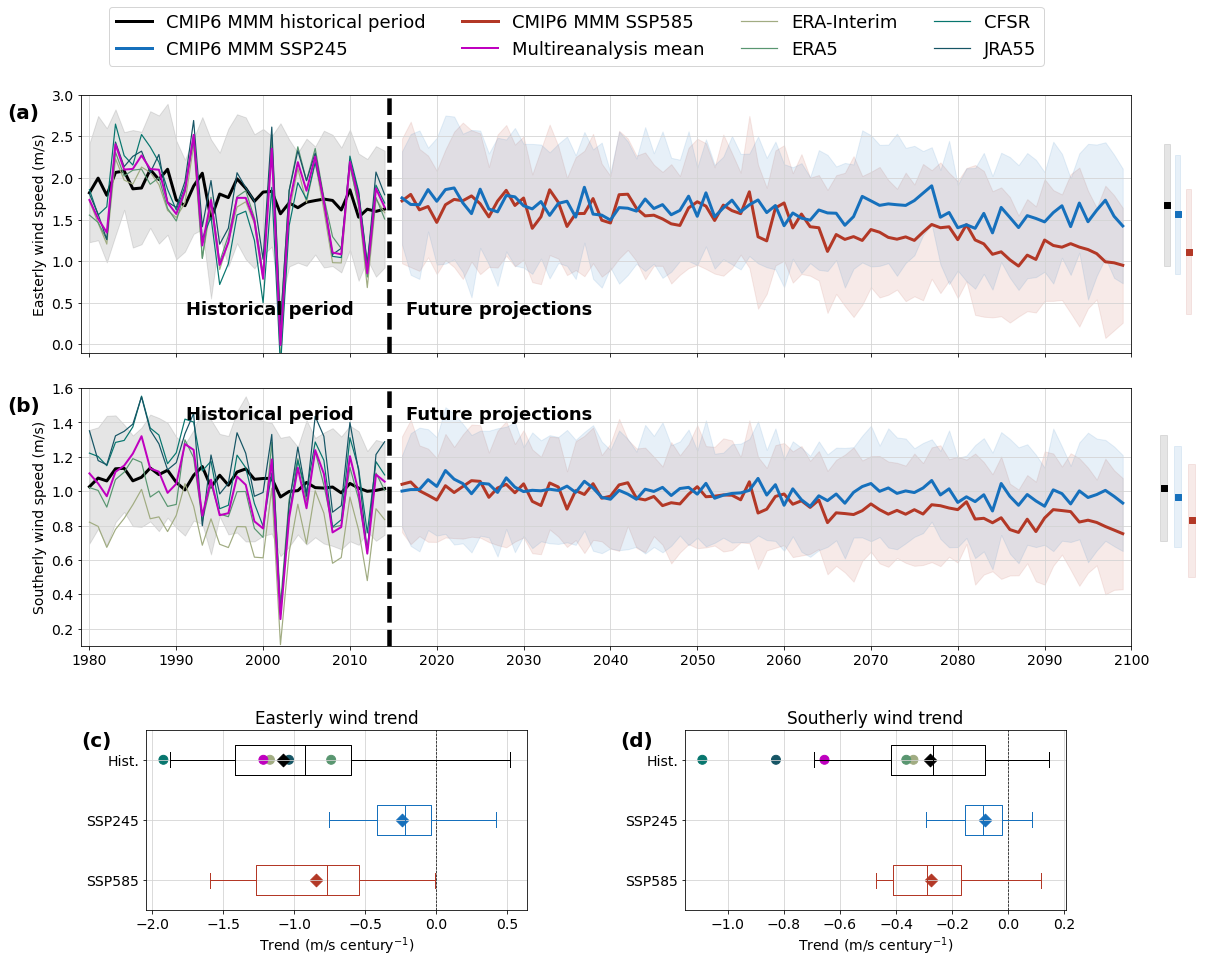

In [38]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,15))
gr = gs.GridSpec(4, 7, figure = fig, height_ratios = [1,1,.05,.7], width_ratios = [.1,1,.1,.1,1,.1,.1])
axs = [fig.add_subplot(gr[0,:-1]),
       fig.add_subplot(gr[1,:-1]),
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[3,4]),
       fig.add_subplot(gr[0,-1]),
       fig.add_subplot(gr[1,-1])]
for ax, label in zip(axs, ['(a)', '(b)', '(c)', '(d)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.07, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    elif ax in axs[2:-1]:
        ax.text(-0.17, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
    else:
        ax.tick_params(color='white', labelcolor='white')
        for spine in ax.spines.values():
            spine.set_color('white')

axs[0].plot(np.arange(1980, 2015, 1), -u_ave_DJF['cmip6'], color = 'k', linewidth = 3)
axs[0].fill_between(np.arange(1980, 2015, 1), -u_ave_DJF['cmip6']+u_sd_DJF_hist, -u_ave_DJF['cmip6']-u_sd_DJF_hist, 
                    color = 'k', alpha = 0.1)
axs[1].plot(np.arange(1980, 2015, 1), v_ave_DJF['cmip6'], color = 'k', linewidth = 3)
axs[1].fill_between(np.arange(1980, 2015, 1), v_ave_DJF['cmip6']-v_sd_DJF_hist, v_ave_DJF['cmip6']+v_sd_DJF_hist, 
                    color = 'k', alpha = 0.1)

for k, cl in zip(keys[:-2], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(np.arange(1980, 2015, 1), -u_ave_DJF[k], color = cl, linewidth = 1.2, label = k)
    axs[1].plot(np.arange(1980, 2015, 1), v_ave_DJF[k], color = cl, linewidth = 1.2, label = k)
    
axs[0].plot(np.arange(1980, 2015, 1), -u_ave_DJF['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(np.arange(2016, 2100, 1), -u_ave_DJF_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[0].fill_between(np.arange(2016, 2100, 1),-u_ave_DJF_ssp85['cmip6']+u_sd_DJF_ssp85, 
                    -u_ave_DJF_ssp85['cmip6']-u_sd_DJF_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[0].plot(np.arange(2016, 2100, 1), -u_ave_DJF_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[0].fill_between(np.arange(2016, 2100, 1),
                    -u_ave_DJF_ssp45['cmip6']+u_sd_DJF_ssp45, -u_ave_DJF_ssp45['cmip6']-u_sd_DJF_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[1].plot(np.arange(1980, 2015, 1), v_ave_DJF['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(np.arange(2016, 2100, 1), v_ave_DJF_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[1].fill_between(np.arange(2016, 2100, 1),v_ave_DJF_ssp85['cmip6']-v_sd_DJF_ssp85, 
                    v_ave_DJF_ssp85['cmip6']+v_sd_DJF_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[1].plot(np.arange(2016, 2100, 1), v_ave_DJF_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[1].fill_between(np.arange(2016, 2100, 1),
                    v_ave_DJF_ssp45['cmip6']-v_sd_DJF_ssp45, v_ave_DJF_ssp45['cmip6']+v_sd_DJF_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[-2].fill_between([-.1,0], 
                     -u_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_DJF_hist.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_DJF_hist.isel(time=slice(-10,None)).mean('time'), 
                     color = 'k', alpha = 0.1)
axs[-2].fill_between([.1,.2], 
                     -u_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_DJF_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_DJF_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.2), alpha = 0.1)
axs[-2].fill_between([.3,.4], 
                     -u_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_DJF_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_DJF_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.8), alpha = 0.1)

axs[-2].scatter(-0.05, -u_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = 'k')
axs[-2].scatter(.15, -u_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.2))
axs[-2].scatter(.35, -u_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.8))

axs[-1].fill_between([-.1,0], 
                     v_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_DJF_hist.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_DJF_hist.isel(time=slice(-10,None)).mean('time'), 
                     color = 'k', alpha = 0.1)
axs[-1].fill_between([.1,.2], 
                     v_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_DJF_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_DJF_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.2), alpha = 0.1)
axs[-1].fill_between([.3,.4], 
                     v_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_DJF_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_DJF_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.8), alpha = 0.1)
axs[-1].scatter(-0.05, v_ave_DJF['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = 'k')
axs[-1].scatter(.15, v_ave_DJF_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.2))
axs[-1].scatter(.35, v_ave_DJF_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.8))

axs[-2].set_ylim(-.1,3)
axs[-1].set_ylim(.1,1.6)
axs[-2].set_xlim(-.2, .5)
axs[-1].set_yticklabels([])
axs[-2].set_yticklabels([])
axs[-1].tick_params(color='white', labelcolor='white')
for spine in axs[-1].spines.values():
    spine.set_color('white')
axs[-2].tick_params(color='white', labelcolor='white')
for spine in axs[-2].spines.values():
    spine.set_color('white') 

axs[0].axvline(x = 2015-.55, linewidth = 4.5, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015-.55, linewidth = 4.5, linestyle = '--', color = 'k')
axs[0].set_ylim(-.1,3)
axs[1].set_ylim(.1,1.6)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Easterly wind speed (m/s)')
axs[1].set_ylabel('Southerly wind speed (m/s)')
axs[0].text(0.1, .15, 'Historical period', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[0].text(0.31, .15, 'Future projections', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.1, .88, 'Historical period', transform = axs[1].transAxes, size = 18, weight = 'bold')
axs[1].text(0.31, .88, 'Future projections', transform = axs[1].transAxes, size = 18, weight = 'bold')

axs[2].axvline(x = 0, color = 'k', linestyle = '--', linewidth=.7)
axs[3].axvline(x = 0, color = 'k', linestyle = '--', linewidth=.7)
axs[2].boxplot(ut_cmip_DJF_hist['trend']*100, positions = [0], widths = .5, vert = False,
               showfliers = False, medianprops=dict(color='k'))
axs[2].boxplot(ut_cmip_DJF_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [-1], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[2].boxplot(ut_cmip_DJF_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [-2], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[2].scatter(ut_re_DJF['trend'].drop_sel(x = 'cmip6')*100, np.zeros(5), s = 80,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[2].scatter(ut_re_DJF['trend'].sel(x = 'cmip6')*100, 0, s = 80, c = 'k', marker = 'D')
axs[2].scatter(ut_cmip_DJF_ssp45['trend'].sel(x = 'cmip6')*100, -1, s = 80, marker = 'D', color = cmocean.cm.balance(.2))
axs[2].scatter(ut_cmip_DJF_ssp85['trend'].sel(x = 'cmip6')*100, -2, s = 80, marker = 'D', color = cmocean.cm.balance(.8))

axs[3].boxplot(vt_cmip_DJF_hist['trend']*100, positions = [0], widths = .5, vert = False, 
               showfliers = False, medianprops=dict(color='k'))
axs[3].boxplot(vt_cmip_DJF_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [-1], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[3].boxplot(vt_cmip_DJF_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [-2], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[3].scatter(vt_re_DJF['trend'].drop_sel(x = 'cmip6')*100, np.zeros(5), s = 80,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[3].scatter(vt_re_DJF['trend'].sel(x = 'cmip6')*100, 0, c = 'k', s = 80, marker = 'D')
axs[3].scatter(vt_cmip_DJF_ssp45['trend'].sel(x = 'cmip6')*100, -1, s = 80, marker = 'D', color = cmocean.cm.balance(.2))
axs[3].scatter(vt_cmip_DJF_ssp85['trend'].sel(x = 'cmip6')*100, -2, s = 80, marker = 'D', color = cmocean.cm.balance(.8))

axs[2].set_yticks([-2, -1, 0])
axs[2].set_yticklabels(['SSP585', 'SSP245', 'Hist.'])
axs[2].set_title('Easterly wind trend')
axs[3].set_yticks([-2, -1, 0])
axs[3].set_yticklabels(['SSP585', 'SSP245', 'Hist.'])
axs[3].set_title('Southerly wind trend')
axs[2].set_xlabel('Trend (m/s century$^{-1}$)')
axs[3].set_xlabel('Trend (m/s century$^{-1}$)')

fig.legend(handles = legend_elements, ncol = 4, fontsize = 18, bbox_to_anchor = (0.8, .97))

plt.savefig('../results/v6/sup_fig4_djf_new.jpg', bbox_inches = 'tight', dpi = 800)

In [20]:
print(ut_re_DJF['trend']*100)

<xarray.DataArray 'trend' (x: 6)>
array([-1.07724143, -1.17143566, -0.73959026, -1.92294103, -1.03685076,
       -1.21770443])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [22]:
print(ut_re_DJF['p'])

<xarray.DataArray 'p' (x: 6)>
array([1.25878001e-04, 1.81897748e-01, 3.06542843e-01, 6.90972597e-02,
       2.44214385e-01, 1.91371790e-01])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [23]:
print(vt_re_DJF['trend']*100)

<xarray.DataArray 'trend' (x: 6)>
array([-0.27821843, -0.33809696, -0.36367403, -1.09070378, -0.82829266,
       -0.65519186])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [24]:
print(vt_re_DJF['p'])

<xarray.DataArray 'p' (x: 6)>
array([0.00052994, 0.26798634, 0.25590862, 0.00286091, 0.04373692,
       0.06084928])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [25]:
print(ut_cmip_DJF_ssp45['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.23896713)
Coordinates:
    x        <U16 'cmip6'


In [26]:
print(ut_cmip_DJF_ssp45['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(4.15413386e-05)
Coordinates:
    x        <U16 'cmip6'


In [27]:
print(vt_cmip_DJF_ssp45['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.08466379)
Coordinates:
    x        <U16 'cmip6'


In [28]:
print(vt_cmip_DJF_ssp45['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(1.24730144e-05)
Coordinates:
    x        <U16 'cmip6'


In [29]:
print(ut_cmip_DJF_ssp85['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.84646826)
Coordinates:
    x        <U16 'cmip6'


In [30]:
print(ut_cmip_DJF_ssp85['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(0.)
Coordinates:
    x        <U16 'cmip6'


In [31]:
print(vt_cmip_DJF_ssp85['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.27728674)
Coordinates:
    x        <U16 'cmip6'


In [32]:
print(vt_cmip_DJF_ssp85['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(0.)
Coordinates:
    x        <U16 'cmip6'


In [30]:
v_ave_DJF['cmip6'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')

<xarray.DataArray ()>
array(1.01887464)
Coordinates:
    height   float64 10.0

In [31]:
v_ave_DJF_ssp45['cmip6'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')

<xarray.DataArray ()>
array(0.96850022)
Coordinates:
    height   float64 10.0

In [32]:
v_ave_DJF_ssp85['cmip6'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')

<xarray.DataArray ()>
array(0.82980894)
Coordinates:
    height   float64 10.0

In [35]:
100-0.83*100/1.1

24.545454545454547

# JJA plot

In [39]:
u_ave_xarray_JJA_hist = u_ave_JJA['cmip6']
v_ave_xarray_JJA_hist = v_ave_JJA['cmip6']
for k in model_keys:
    u_ave_xarray_JJA_hist = xr.concat([u_ave_xarray_JJA_hist, u_ave_JJA[k]], dim = 'model')
    v_ave_xarray_JJA_hist = xr.concat([v_ave_xarray_JJA_hist, v_ave_JJA[k]], dim = 'model')
u_ave_xarray_JJA_hist['model'] = ['cmip6']+model_keys
v_ave_xarray_JJA_hist['model'] = ['cmip6']+model_keys

u_ave_xarray_JJA_ssp45 = u_ave_JJA_ssp45['cmip6']
v_ave_xarray_JJA_ssp45 = v_ave_JJA_ssp45['cmip6']
for k in model_keys:
    u_ave_xarray_JJA_ssp45 = xr.concat([u_ave_xarray_JJA_ssp45, u_ave_JJA_ssp45[k]], dim = 'model')
    v_ave_xarray_JJA_ssp45 = xr.concat([v_ave_xarray_JJA_ssp45, v_ave_JJA_ssp45[k]], dim = 'model')
u_ave_xarray_JJA_ssp45['model'] = ['cmip6']+model_keys
v_ave_xarray_JJA_ssp45['model'] = ['cmip6']+model_keys

u_ave_xarray_JJA_ssp85 = u_ave_JJA_ssp85['cmip6']
v_ave_xarray_JJA_ssp85 = v_ave_JJA_ssp85['cmip6']
for k in model_keys:
    u_ave_xarray_JJA_ssp85 = xr.concat([u_ave_xarray_JJA_ssp85, u_ave_JJA_ssp85[k]], dim = 'model')
    v_ave_xarray_JJA_ssp85 = xr.concat([v_ave_xarray_JJA_ssp85, v_ave_JJA_ssp85[k]], dim = 'model')
u_ave_xarray_JJA_ssp85['model'] = ['cmip6']+model_keys
v_ave_xarray_JJA_ssp85['model'] = ['cmip6']+model_keys

In [40]:
u_sd_JJA_hist = u_ave_xarray_JJA_hist.sel(model = model_keys).std('model')
v_sd_JJA_hist = v_ave_xarray_JJA_hist.sel(model = model_keys).std('model')
u_sd_JJA_ssp45 = u_ave_xarray_JJA_ssp45.sel(model = model_keys).std('model')
v_sd_JJA_ssp45 = v_ave_xarray_JJA_ssp45.sel(model = model_keys).std('model')
u_sd_JJA_ssp85 = u_ave_xarray_JJA_ssp85.sel(model = model_keys).std('model')
v_sd_JJA_ssp85 = v_ave_xarray_JJA_ssp85.sel(model = model_keys).std('model')

In [41]:
MK_class = Mann_Kendall_test(-u_ave_xarray_JJA_hist, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_JJA_hist = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_JJA_hist, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_JJA_hist = MK_class.compute()

In [42]:
MK_class = Mann_Kendall_test(-u_ave_xarray_JJA_ssp85, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_JJA_ssp85 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_JJA_ssp85, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_JJA_ssp85 = MK_class.compute()

In [43]:
MK_class = Mann_Kendall_test(-u_ave_xarray_JJA_ssp45, 'time', coords_name = {'time':'time', 'model':'x'})
ut_cmip_JJA_ssp45 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_JJA_ssp45, 'time', coords_name = {'time':'time', 'model':'x'})
vt_cmip_JJA_ssp45 = MK_class.compute()

In [44]:
u_re_concat = u_ave_JJA['cmip6']
v_re_concat = v_ave_JJA['cmip6']
for k in keys[:-1]:
    u_ave_JJA[k]['time'] = u_ave_JJA['cmip6']['time']
    u_re_concat = xr.concat([u_re_concat, u_ave_JJA[k]], dim = 'model')
    v_ave_JJA[k]['time'] = v_ave_JJA['cmip6']['time']
    v_re_concat = xr.concat([v_re_concat, v_ave_JJA[k]], dim = 'model')
u_re_concat['model'] = ['cmip6']+keys[:-1]
v_re_concat['model'] = ['cmip6']+keys[:-1]

MK_class = Mann_Kendall_test(-u_re_concat, 'time', coords_name = {'time':'time', 'model':'x'})
ut_re_JJA = MK_class.compute()
MK_class = Mann_Kendall_test(v_re_concat, 'time', coords_name = {'time':'time', 'model':'x'})
vt_re_JJA = MK_class.compute()

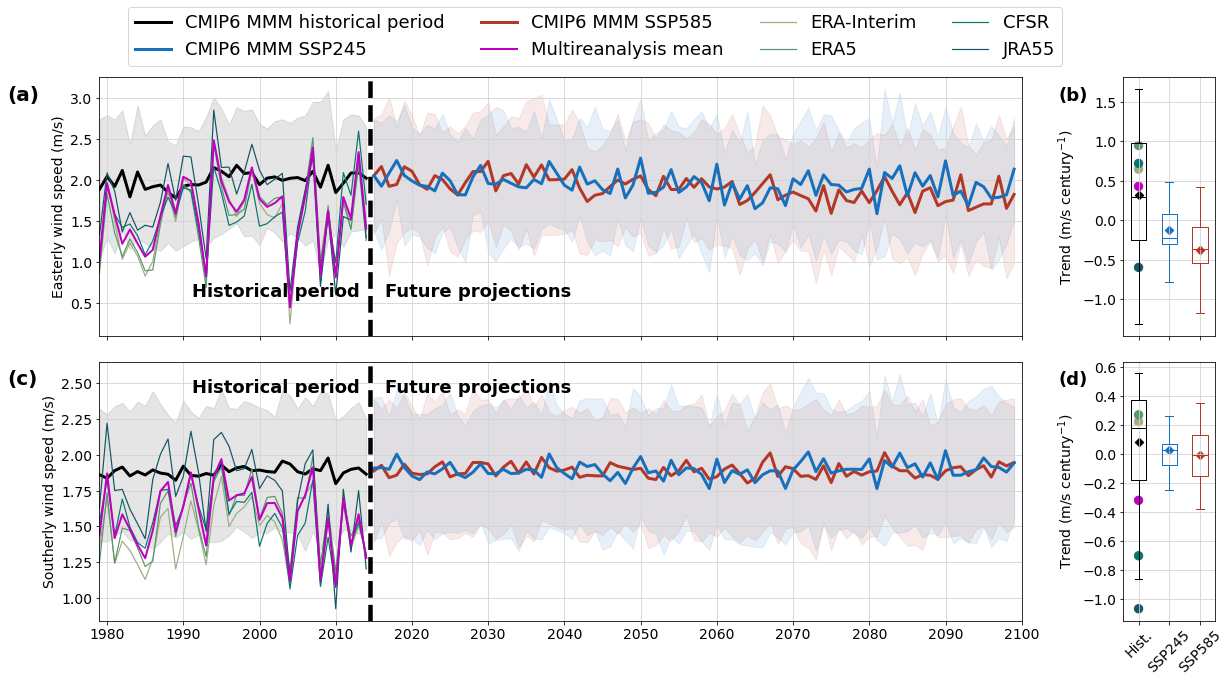

In [45]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, hspace = 0.1, width_ratios = [1, .1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['(a)', '(c)', '(b)', '(d)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.1, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    else:
        ax.text(-0.7, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim(-.5, 2.5)

        
axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA['cmip6'], color = 'k', linewidth = 3)
axs[0].fill_between(np.arange(1979, 2015, 1), -u_ave_JJA['cmip6']+u_sd_JJA_hist, -u_ave_JJA['cmip6']-u_sd_JJA_hist, 
                    color = 'k', alpha = 0.1)
axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA['cmip6'], color = 'k', linewidth = 3)
axs[1].fill_between(np.arange(1979, 2015, 1), v_ave_JJA['cmip6']-v_sd_JJA_hist, v_ave_JJA['cmip6']+v_sd_JJA_hist, 
                    color = 'k', alpha = 0.1)

for k, cl in zip(keys[:-2], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA[k], color = cl, linewidth = 1.2, label = k)
    axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA[k], color = cl, linewidth = 1.2, label = k)
    
axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(np.arange(2015, 2100, 1), -u_ave_JJA_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[0].fill_between(np.arange(2015, 2100, 1),-u_ave_JJA_ssp85['cmip6']+u_sd_JJA_ssp85, 
                    -u_ave_JJA_ssp85['cmip6']-u_sd_JJA_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[0].plot(np.arange(2015, 2100, 1), -u_ave_JJA_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[0].fill_between(np.arange(2015, 2100, 1),
                    -u_ave_JJA_ssp45['cmip6']+u_sd_JJA_ssp45, -u_ave_JJA_ssp45['cmip6']-u_sd_JJA_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(np.arange(2015, 2100, 1), v_ave_JJA_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[1].fill_between(np.arange(2015, 2100, 1),v_ave_JJA_ssp85['cmip6']-v_sd_JJA_ssp85, 
                    v_ave_JJA_ssp85['cmip6']+v_sd_JJA_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[1].plot(np.arange(2015, 2100, 1), v_ave_JJA_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[1].fill_between(np.arange(2015, 2100, 1),
                    v_ave_JJA_ssp45['cmip6']-v_sd_JJA_ssp45, v_ave_JJA_ssp45['cmip6']+v_sd_JJA_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[0].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
#axs[0].set_ylim(0.5, 2.5)
#axs[1].set_ylim(1, 2)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Easterly wind speed (m/s)')
axs[1].set_ylabel('Southerly wind speed (m/s)')
axs[0].text(0.1, .15, 'Historical period', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[0].text(0.31, .15, 'Future projections', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.1, .88, 'Historical period', transform = axs[1].transAxes, size = 18, weight = 'bold')
axs[1].text(0.31, .88, 'Future projections', transform = axs[1].transAxes, size = 18, weight = 'bold')

axs[2].boxplot(ut_cmip_JJA_hist['trend']*100, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[2].boxplot(ut_cmip_JJA_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[2].boxplot(ut_cmip_JJA_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[2].scatter(np.zeros(5), ut_re_JJA['trend'].drop_sel(x = 'cmip6')*100, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[2].scatter(0, ut_re_JJA['trend'].sel(x = 'cmip6')*100, c = 'k', marker = 'D')
axs[2].scatter(1, ut_cmip_JJA_ssp45['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.2))
axs[2].scatter(2, ut_cmip_JJA_ssp85['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.8))

axs[3].boxplot(vt_cmip_JJA_hist['trend']*100, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[3].boxplot(vt_cmip_JJA_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[3].boxplot(vt_cmip_JJA_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[3].scatter(np.zeros(5), vt_re_JJA['trend'].drop_sel(x = 'cmip6')*100, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[3].scatter(0, vt_re_JJA['trend'].sel(x = 'cmip6')*100, c = 'k', marker = 'D')
axs[3].scatter(1, vt_cmip_JJA_ssp45['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.2))
axs[3].scatter(2, vt_cmip_JJA_ssp85['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.8))

axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels([])
axs[3].set_xticks([0,1,2])
axs[3].set_xticklabels(['Hist.', 'SSP245', 'SSP585'], rotation = 45)
axs[2].set_ylabel('Trend (m/s century$^{-1}$)')
axs[3].set_ylabel('Trend (m/s century$^{-1}$)')

fig.legend(handles = legend_elements, ncol = 4, fontsize = 18, bbox_to_anchor = (0.8, .99))

plt.savefig('../results/v6/sup_fig4_jja.jpg', bbox_inches = 'tight', dpi = 800)

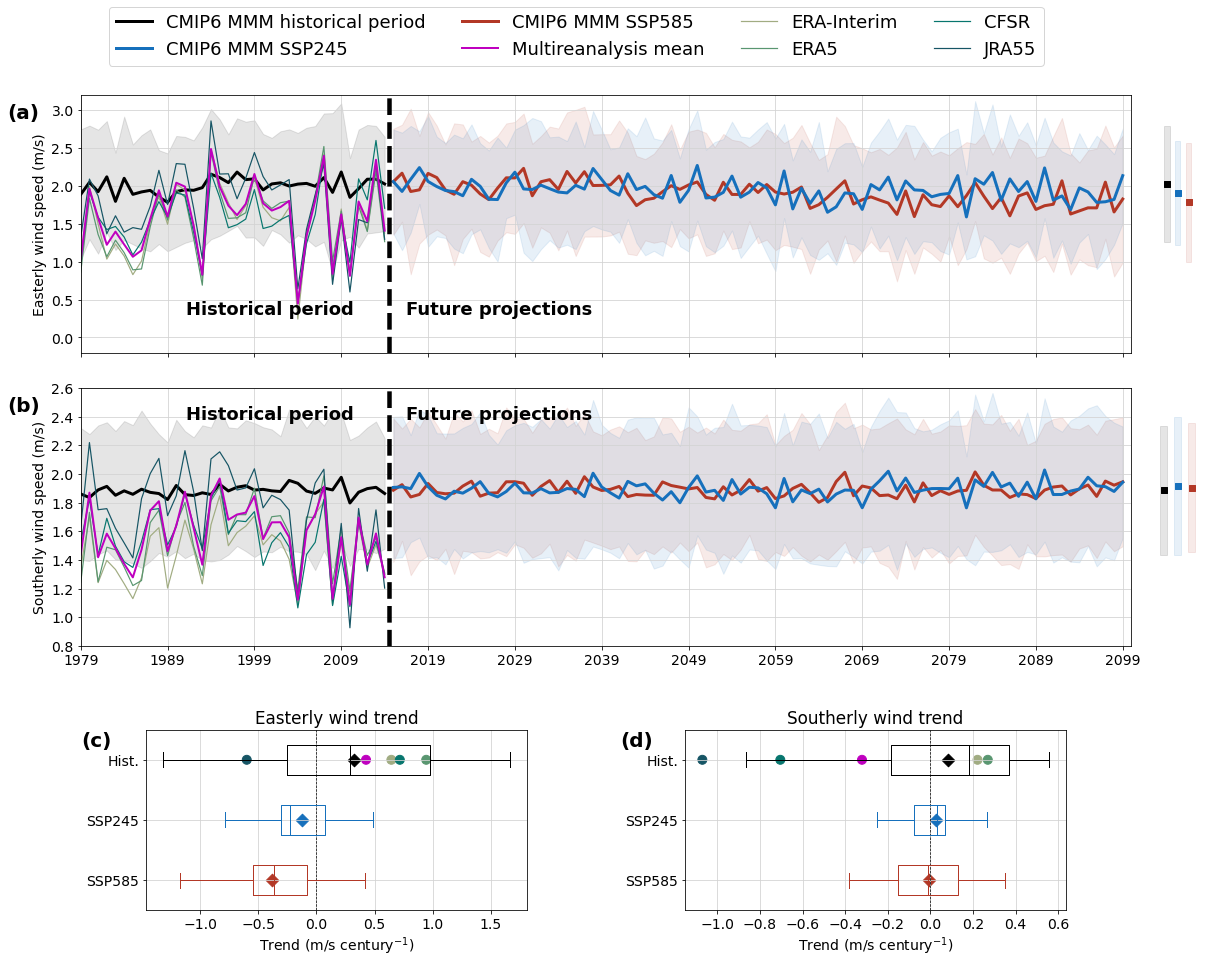

In [51]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,15))
gr = gs.GridSpec(4, 7, figure = fig, height_ratios = [1,1,.05,.7], width_ratios = [.1,1,.1,.1,1,.1,.1])
axs = [fig.add_subplot(gr[0,:-1]),
       fig.add_subplot(gr[1,:-1]),
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[3,4]),
       fig.add_subplot(gr[0,-1]),
       fig.add_subplot(gr[1,-1])]
for ax, label in zip(axs, ['(a)', '(b)', '(c)', '(d)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.07, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
        ax.set_xticks(np.arange(1979, 2110, 10))
        ax.set_xlim(1979, 2100)
    elif ax in axs[2:-1]:
        ax.text(-0.17, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
    else:
        ax.tick_params(color='white', labelcolor='white')
        for spine in ax.spines.values():
            spine.set_color('white')

axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA['cmip6'], color = 'k', linewidth = 3)
axs[0].fill_between(np.arange(1979, 2015, 1), -u_ave_JJA['cmip6']+u_sd_JJA_hist, -u_ave_JJA['cmip6']-u_sd_JJA_hist, 
                    color = 'k', alpha = 0.1)
axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA['cmip6'], color = 'k', linewidth = 3)
axs[1].fill_between(np.arange(1979, 2015, 1), v_ave_JJA['cmip6']-v_sd_JJA_hist, v_ave_JJA['cmip6']+v_sd_JJA_hist, 
                    color = 'k', alpha = 0.1)

for k, cl in zip(keys[:-2], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA[k], color = cl, linewidth = 1.2, label = k)
    axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA[k], color = cl, linewidth = 1.2, label = k)
    
axs[0].plot(np.arange(1979, 2015, 1), -u_ave_JJA['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(np.arange(2015, 2100, 1), -u_ave_JJA_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[0].fill_between(np.arange(2015, 2100, 1),-u_ave_JJA_ssp85['cmip6']+u_sd_JJA_ssp85, 
                    -u_ave_JJA_ssp85['cmip6']-u_sd_JJA_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[0].plot(np.arange(2015, 2100, 1), -u_ave_JJA_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[0].fill_between(np.arange(2015, 2100, 1),
                    -u_ave_JJA_ssp45['cmip6']+u_sd_JJA_ssp45, -u_ave_JJA_ssp45['cmip6']-u_sd_JJA_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[1].plot(np.arange(1979, 2015, 1), v_ave_JJA['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(np.arange(2015, 2100, 1), v_ave_JJA_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[1].fill_between(np.arange(2015, 2100, 1),v_ave_JJA_ssp85['cmip6']-v_sd_JJA_ssp85, 
                    v_ave_JJA_ssp85['cmip6']+v_sd_JJA_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[1].plot(np.arange(2015, 2100, 1), v_ave_JJA_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[1].fill_between(np.arange(2015, 2100, 1),
                    v_ave_JJA_ssp45['cmip6']-v_sd_JJA_ssp45, v_ave_JJA_ssp45['cmip6']+v_sd_JJA_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[-2].fill_between([-.1,0], 
                     -u_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_JJA_hist.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_JJA_hist.isel(time=slice(-10,None)).mean('time'), 
                     color = 'k', alpha = 0.1)
axs[-2].fill_between([.1,.2], 
                     -u_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_JJA_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_JJA_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.2), alpha = 0.1)
axs[-2].fill_between([.3,.4], 
                     -u_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')+u_sd_JJA_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     -u_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')-u_sd_JJA_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.8), alpha = 0.1)

axs[-2].scatter(-0.05, -u_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = 'k')
axs[-2].scatter(.15, -u_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.2))
axs[-2].scatter(.35, -u_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.8))

axs[-1].fill_between([-.1,0], 
                     v_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_JJA_hist.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_JJA_hist.isel(time=slice(-10,None)).mean('time'), 
                     color = 'k', alpha = 0.1)
axs[-1].fill_between([.1,.2], 
                     v_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_JJA_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_JJA_ssp45.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.2), alpha = 0.1)
axs[-1].fill_between([.3,.4], 
                     v_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')-v_sd_JJA_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     v_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time')+v_sd_JJA_ssp85.isel(time=slice(-10,None)).mean('time'), 
                     color = cmocean.cm.balance(.8), alpha = 0.1)
axs[-1].scatter(-0.05, v_ave_JJA['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = 'k')
axs[-1].scatter(.15, v_ave_JJA_ssp45['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.2))
axs[-1].scatter(.35, v_ave_JJA_ssp85['cmip6'].isel(time=slice(-10,None)).mean('time'), marker = 's', color = cmocean.cm.balance(.8))

axs[-2].set_ylim(-.2,3.2)
axs[-1].set_ylim(.8,2.6)
axs[-2].set_xlim(-.2, .5)
axs[-1].set_yticklabels([])
axs[-2].set_yticklabels([])
axs[-1].tick_params(color='white', labelcolor='white')
for spine in axs[-1].spines.values():
    spine.set_color('white')
axs[-2].tick_params(color='white', labelcolor='white')
for spine in axs[-2].spines.values():
    spine.set_color('white') 

axs[0].axvline(x = 2015-.55, linewidth = 4.5, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015-.55, linewidth = 4.5, linestyle = '--', color = 'k')
axs[0].set_ylim(-.2,3.2)
axs[1].set_ylim(.8,2.6)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Easterly wind speed (m/s)')
axs[1].set_ylabel('Southerly wind speed (m/s)')
axs[0].text(0.1, .15, 'Historical period', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[0].text(0.31, .15, 'Future projections', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.1, .88, 'Historical period', transform = axs[1].transAxes, size = 18, weight = 'bold')
axs[1].text(0.31, .88, 'Future projections', transform = axs[1].transAxes, size = 18, weight = 'bold')

axs[2].axvline(x = 0, color = 'k', linestyle = '--', linewidth=.7)
axs[3].axvline(x = 0, color = 'k', linestyle = '--', linewidth=.7)
axs[2].boxplot(ut_cmip_JJA_hist['trend']*100, positions = [0], widths = .5, vert = False,
               showfliers = False, medianprops=dict(color='k'))
axs[2].boxplot(ut_cmip_JJA_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [-1], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[2].boxplot(ut_cmip_JJA_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [-2], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[2].scatter(ut_re_JJA['trend'].drop_sel(x = 'cmip6')*100, np.zeros(5), s = 80,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[2].scatter(ut_re_JJA['trend'].sel(x = 'cmip6')*100, 0, s = 80, c = 'k', marker = 'D')
axs[2].scatter(ut_cmip_JJA_ssp45['trend'].sel(x = 'cmip6')*100, -1, s = 80, marker = 'D', color = cmocean.cm.balance(.2))
axs[2].scatter(ut_cmip_JJA_ssp85['trend'].sel(x = 'cmip6')*100, -2, s = 80, marker = 'D', color = cmocean.cm.balance(.8))

axs[3].boxplot(vt_cmip_JJA_hist['trend']*100, positions = [0], widths = .5, vert = False, 
               showfliers = False, medianprops=dict(color='k'))
axs[3].boxplot(vt_cmip_JJA_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [-1], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[3].boxplot(vt_cmip_JJA_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [-2], widths = .5, vert = False,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[3].scatter(vt_re_JJA['trend'].drop_sel(x = 'cmip6')*100, np.zeros(5), s = 80,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[3].scatter(vt_re_JJA['trend'].sel(x = 'cmip6')*100, 0, c = 'k', s = 80, marker = 'D')
axs[3].scatter(vt_cmip_JJA_ssp45['trend'].sel(x = 'cmip6')*100, -1, s = 80, marker = 'D', color = cmocean.cm.balance(.2))
axs[3].scatter(vt_cmip_JJA_ssp85['trend'].sel(x = 'cmip6')*100, -2, s = 80, marker = 'D', color = cmocean.cm.balance(.8))

axs[2].set_yticks([-2, -1, 0])
axs[2].set_yticklabels(['SSP585', 'SSP245', 'Hist.'])
axs[2].set_title('Easterly wind trend')
axs[3].set_yticks([-2, -1, 0])
axs[3].set_yticklabels(['SSP585', 'SSP245', 'Hist.'])
axs[3].set_title('Southerly wind trend')
axs[2].set_xlabel('Trend (m/s century$^{-1}$)')
axs[3].set_xlabel('Trend (m/s century$^{-1}$)')

fig.legend(handles = legend_elements, ncol = 4, fontsize = 18, bbox_to_anchor = (0.8, .97))

plt.savefig('../results/v6/sup_fig4_jja_new.jpg', bbox_inches = 'tight', dpi = 800)

In [46]:
print(ut_re_JJA['trend']*100)

<xarray.DataArray 'trend' (x: 6)>
array([ 0.31931459,  0.64486188,  0.94489572,  0.7178861 , -0.59961183,
        0.42700797])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [44]:
print(ut_re_JJA['p'])

<xarray.DataArray 'p' (x: 6)>
array([0.07005128, 0.4537673 , 0.21515988, 0.20524714, 0.88089887,
       0.37596351])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [45]:
print(vt_re_JJA['trend']*100)

<xarray.DataArray 'trend' (x: 6)>
array([ 0.0841468 ,  0.22162214,  0.26986356, -0.70423232, -1.07028642,
       -0.32075826])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [46]:
print(vt_re_JJA['p'])

<xarray.DataArray 'p' (x: 6)>
array([0.09932637, 0.4537673 , 0.69283851, 0.08365644, 0.09386166,
       0.63355348])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [47]:
print(ut_cmip_JJA_ssp45['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.12803481)
Coordinates:
    x        <U16 'cmip6'


In [48]:
print(ut_cmip_JJA_ssp45['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(0.02538159)
Coordinates:
    x        <U16 'cmip6'


In [49]:
print(vt_cmip_JJA_ssp45['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(0.02530038)
Coordinates:
    x        <U16 'cmip6'


In [50]:
print(vt_cmip_JJA_ssp45['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(0.25963205)
Coordinates:
    x        <U16 'cmip6'


In [51]:
print(ut_cmip_JJA_ssp85['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.37865178)
Coordinates:
    x        <U16 'cmip6'


In [52]:
print(ut_cmip_JJA_ssp85['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(1.34940681e-09)
Coordinates:
    x        <U16 'cmip6'


In [53]:
print(vt_cmip_JJA_ssp85['trend'].sel(x='cmip6')*100)

<xarray.DataArray 'trend' ()>
array(-0.00651149)
Coordinates:
    x        <U16 'cmip6'


In [54]:
print(vt_cmip_JJA_ssp85['p'].sel(x='cmip6'))

<xarray.DataArray 'p' ()>
array(0.70709998)
Coordinates:
    x        <U16 'cmip6'


# Seasonal cycle

In [35]:
uas = xr.open_dataset('../data/uas-monthly-1979_2015-erai.nc')['uas'].sel(time = slice('2005-01-01', '2015-01-01')).groupby('time.month').mean('time')
uas = (uas*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
vas = xr.open_dataset('../data/vas-monthly-1979_2015-erai.nc')['vas'].sel(time = slice('2005-01-01', '2015-01-01')).groupby('time.month').mean('time')
vas = (vas*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in keys[1:]:
    u = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('2005-01-01', '2015-01-01')).groupby('time.month').mean('time')
    uas = xr.concat([uas,
                     (u*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))],
                     dim = 'model')
    v = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('2005-01-01', '2015-01-01')).groupby('time.month').mean('time')
    vas = xr.concat([vas,
                    (v*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))],
                     dim = 'model')
uas['model'] = keys
vas['model'] = keys

In [36]:
uas_ssp45 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas'].sel(time = slice('2090-01-01', '2100-01-01')).groupby('time.month').mean('time')
uas_ssp45 = (uas_ssp45*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
uas_ssp85 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2090-01-01', '2100-01-01')).groupby('time.month').mean('time')
uas_ssp85 = (uas_ssp85*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [37]:
vas_ssp45 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas'].sel(time = slice('2090-01-01', '2100-01-01')).groupby('time.month').mean('time')
vas_ssp45 = (vas_ssp45*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
vas_ssp85 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2090-01-01', '2100-01-01')).groupby('time.month').mean('time')
vas_ssp85 = (vas_ssp85*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

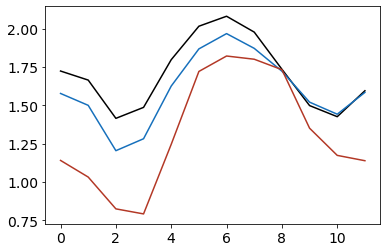

In [38]:
plt.plot(-uas.sel(model = 'cmip6'), color = 'k')
plt.plot(-uas_ssp45, color = cmocean.cm.balance(.2))
plt.plot(-uas_ssp85, color = cmocean.cm.balance(.8))

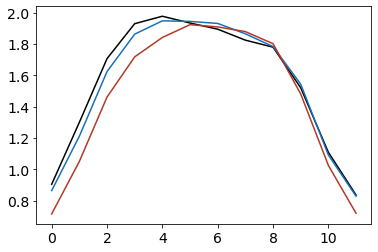

In [39]:
plt.plot(vas.sel(model = 'cmip6'), color = 'k')
plt.plot(vas_ssp45, color = cmocean.cm.balance(.2))
plt.plot(vas_ssp85, color = cmocean.cm.balance(.8))